<a href="https://colab.research.google.com/github/phoid/DeepLearning/blob/main/Gaussian_Blur_2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Gaussian Blurs: A Notebook
- This notebook is mostly just a crude practice notebook for CNNs in PyTorch. It implements some of the common practice CNN layers and activations with very minimal external or internal normalization techniques
- Also implements a limited grid search for the optimal # of units for the linear layer

Achieves ~ 7.5% Error rate or 92.5% Accuracy

Improves to ~ 4% or 96% respectively using the same architecture but with increased convolution output channels

In [23]:
# import libraries
import numpy as np

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for getting summary info on models
from torchsummary import summary

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-23-2891f650ed36>:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [24]:
# Create the gaussian blurs
nPerClass = 1000
imgSize   = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# the two widths (a.u.)
widths = [1.8,2.4]

# initialize tensors containing images and labels
images = torch.zeros(2*nPerClass,1,imgSize,imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

  # create the gaussian with random centers
  ro = 2*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

  # and add noise
  G  = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor
  images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
  labels[i] = i%2

labels = labels[:,None]

In [25]:
images.shape

torch.Size([2000, 1, 91, 91])

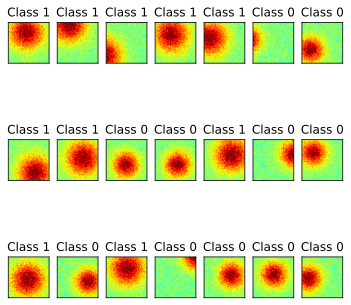

In [26]:
fig, axs = plt.subplots(3,7, figsize=(6,6))

imgsToShow = torch.randperm(2*nPerClass)[:3*7]
for i,ax in enumerate(axs.flatten()):
  whichpic = imgsToShow[i]
  G = np.squeeze( images[whichpic,:,:] )
  ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
  ax.set_title('Class %s'%int(labels[whichpic].item()))
  ax.set_xticks([])
  ax.set_yticks([])
# for i in axs.flatten():
#   np.random
#   i.plot
plt.show()

In [27]:
# split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=.1)

# create the datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# create the dataloaders
batchsize = 32
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])


In [28]:
def imSize(pixels, padding, ksize, stride, pool):
  """
  Calculates the size of an image
  after convolution and max pooling

  returns integer
  """
  return int((((pixels + 2*(padding) - ksize)/stride) + 1)//pool)

## Create the model architecture

In [29]:
class cnnModel(nn.Module):
  def __init__(self, fcsize=50):
    super().__init__()

    # Convolutiob layers
    self.conv1 = nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
    self.resSize1 =  imSize(91,1,3,1,2)

    self.conv2 = nn.Conv2d(6, 4, kernel_size=3, stride=1, padding=1)
    self.resSize2 =  imSize(self.resSize1,1,3,1,2)

    # Fully Connected layers
    expectSize = (self.resSize2**2) * 4
    self.fc1 = nn.Linear(expectSize, fcsize)
    self.fc2 = nn.Linear(fcsize, 2 * fcsize )
    # FC Output layer
    self.output = nn.Linear(2 * fcsize, 1)

    # Flatten layer
    self.flat = nn.Flatten()

  def forward(self, x):
    # Pass through Convolutions
    maps1 = F.relu(self.conv1(x))
    x = F.max_pool2d(maps1, 2)

    maps2 = F.relu(self.conv2(x))
    x = F.max_pool2d(maps2, 2)

    # Reshape X
    x = self.flat(x)

    # Pass through full connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    return self.output(x), maps1, maps2

In [30]:
def createCnn(size=50):
  net = cnnModel(size)

  lossfun = torch.nn.BCEWithLogitsLoss()

  optimizer = torch.optim.Adam(net.parameters(), lr=.001)

  return net, lossfun, optimizer

In [31]:
net, lossfun, optimizer = createCnn()

In [32]:
tmp, y = next(iter(train_loader))

preds, maps1, maps2 = net(tmp)

loss = lossfun(preds, y)

In [33]:
vals = (nn.Sigmoid()(preds) >.5).float()

In [34]:
n = 500
units = np.linspace(5, 500, 10).astype(int)

def train():
  big_trainAcc = []
  big_trainLoss = []

  big_testAcc= []
  for unit in units:
    net, lossfun, optimizer = createCnn(unit)

    epochs = 10

    trainAcc = []
    trainLoss = torch.zeros(epochs)
    testAcc = []

    for epochi in range(epochs):
      batchLoss = []
      batchAcc = []
      for X, y in train_loader:

        # preds and loss
        yPreds, *_ = net(X)
        loss = lossfun(yPreds, y)

        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # batch performance
        batchLoss.append(loss.item())
        batchAcc.append(torch.mean(((nn.Sigmoid()(yPreds) >.5) == y).float()).item())

      trainAcc.append(100*  np.mean(batchAcc))
      trainLoss[epochi] = np.mean(batchLoss)

      # Testing model

    big_trainAcc.append(trainAcc)
    big_trainLoss.append(trainLoss)

    X, y = next(iter(test_loader))
    with torch.no_grad():
      test_preds, *_ = net(X)
    big_testAcc.append(100 * torch.mean(((nn.Sigmoid()(test_preds) >.5) == y).float()))


  return big_trainAcc, big_trainLoss, big_testAcc

In [35]:
trainAcc, trainLoss, testAcc = train()

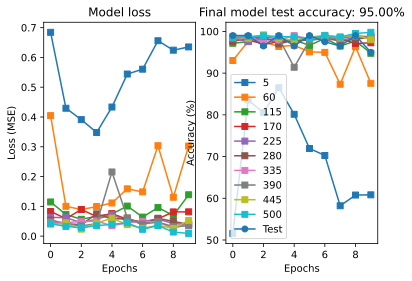

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(6,4))

ax[0].plot(trainLoss,'s-',label='Train')
# ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label=units)
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()


In [37]:
X, y = next(iter(test_loader))
with torch.no_grad():
  test_preds, maps1, maps2 = net(X)

In [38]:
maps1[79, 1].shape

torch.Size([91, 91])

## Let's look at some of the feature maps!

- For a simple task like this, we can understand what the model is learning, so it's fun to take a look.

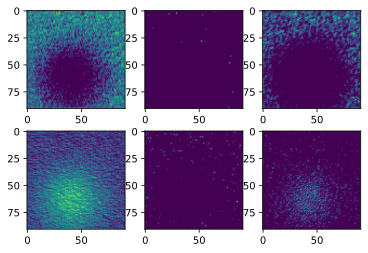

In [39]:
fig, axs = plt.subplots(2,3, figsize=(6,4))

indexPlot = np.random.randint(maps1.shape[0])

for i, ax in enumerate(axs.flatten()):
  ax.imshow(maps1[indexPlot, i])
